# Dataset build

## Segmentation

In [47]:
!python3 -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone https://github.com/facebookresearch/detectron2.git
dist = distutils.core.run_setup("./detectron2/setup.py")
!python3 -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
# python -m pip install git+https://github.com/facebookresearch/detectron2.git

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import matplotlib.pyplot as plt

# import some common libraries
import pandas as pd
import numpy as np
import os, json, cv2, random
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

import pycocotools.mask as mask_util


def binary_mask_to_polygons(mask):
    contours, hierarchy = cv2.findContours(mask.astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    polygons = []
    for contour in contours:
        if len(contour) >= 3:  # valid polygon
            polygon = contour.flatten().tolist()
            reshaped_polygon = [[polygon[i], polygon[i+1]] for i in range(0, len(polygon), 2)]
            polygons.append(reshaped_polygon)
    return polygons

def save_json(file_name, outputs, output_folder):
    instances = outputs["instances"].to("cpu")
    pred_classes = instances.pred_classes.tolist()
    pred_boxes = instances.pred_boxes.tensor.tolist()
    pred_scores = instances.scores.tolist()
    pred_masks = instances.pred_masks.numpy()
    pred_polygons = [binary_mask_to_polygons(mask) for mask in pred_masks]

    detection_results = []
    for cls, box, score, polygons in zip(pred_classes, pred_boxes, pred_scores, pred_polygons):
        instance_result = {
            "class": cls,
            "box": box,
            "score": score,
            "mask": [{"polygon": polygon} for polygon in polygons]
        }
        detection_results.append(instance_result)

    result_dict = {
        "file_name": file_name,
        "instances": detection_results
    }

    json_output_file_path = os.path.join(output_folder, f"{file_name.rsplit('.', 1)[0]}.json")
    
    os.makedirs(os.path.dirname(json_output_file_path), exist_ok=True)

    with open(json_output_file_path, 'w') as json_file:
        json.dump(result_dict, json_file, indent=4)


def save_test_image(image, file_name, output_folder):
    output_image_path = os.path.join(output_folder, f"test_{file_name}")
    cv2.imwrite(output_image_path, image)

def visualize_single_image(image_path, cfg, predictor, output_folder):
    image = cv2.imread(image_path)
    outputs = predictor(image)
    
    v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.8)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    out_img = out.get_image()[:, :, ::-1]  # Convert RGB to BGR for OpenCV

    plt.imshow(out_img)
    plt.show()
    
    # Save visualized image
    file_name = os.path.basename(image_path)
    save_test_image(out_img, file_name, output_folder)
    
    # Save JSON
    save_json(f"test_{file_name}", outputs, output_folder)

def process_folder(input_folder, output_folder, cfg, predictor):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for file_name in os.listdir(input_folder):
        file_path = os.path.join(input_folder, file_name)
        if file_path.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            im = cv2.imread(file_path)  # Read image in BGR format
            if im is None:
                continue
            im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            outputs = predictor(im_rgb)  # Get predictions from the model

            v = Visualizer(im_rgb, metadata=MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.5)
            out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
            out_img = out.get_image()[:, :, ::-1]  # Convert RGB to BGR for OpenCV

            test_name = f"test_{file_name}"
            
            # Save IMAGE
            save_test_image(out_img, file_name, output_folder)

            # Save JSON
            save_json(test_name, outputs, output_folder)


fatal: destination path 'detectron2' already exists and is not an empty directory.


In [48]:
cfg = get_cfg()
cfg.merge_from_file("/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Segmentation/Detectron/202406_Detectron2/r101_test_6_0618_server/config.yaml")
cfg.MODEL.DEVICE = "cpu"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.WEIGHTS = "/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Segmentation/Detectron/202406_Detectron2/r101_test_6_0618_server/model_final.pth"


predictor = DefaultPredictor(cfg)

# # ! Single test
# image_path = r"/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Transformation/Model_18_0025.jpeg"
# output_folder = f"/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Transformation/Output"
# visualize_single_image(image_path, cfg, predictor, output_folder)

! Folder test
input_folder = '/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Transformation/1-input_reg'
output_folder = '/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Transformation/2-output_seg'
output_json_folder = '/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Transformation/3-output_json'
process_folder(input_folder, output_folder, cfg, predictor)

Loading config /Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Segmentation/Detectron/202406_Detectron2/r101_test_6_0618_server/config.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


[07/28 19:49:01 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Segmentation/Detectron/202406_Detectron2/r101_test_6_0618_server/model_final.pth ...
[Checkpointer] Loading from /Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Segmentation/Detectron/202406_Detectron2/r101_test_6_0618_server/model_final.pth ...
zsh:1: command not found: Folder


## Selection the max area

Mask_0_0 area: 261610.5
Mask_1_0 area: 95710.0
Mask_0_0 area: 39.0
Mask_0_1 area: 39586.5
Mask_1_0 area: 143017.5
Mask_2_0 area: 31731.5
Mask_3_0 area: 143324.0
Mask_0_0 area: 2840252.5
Mask_1_0 area: 1298698.5
Mask_2_0 area: 43134.5
Mask_3_0 area: 1212909.0


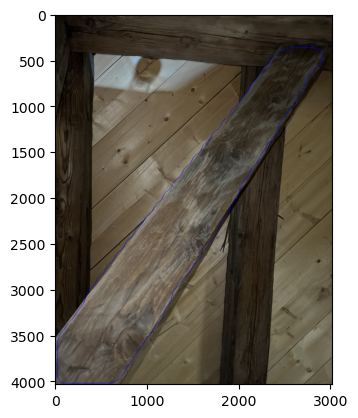

Mask_0_0 area: 5098071.0
Mask_1_0 area: 896554.0
Mask_2_0 area: 3100348.0


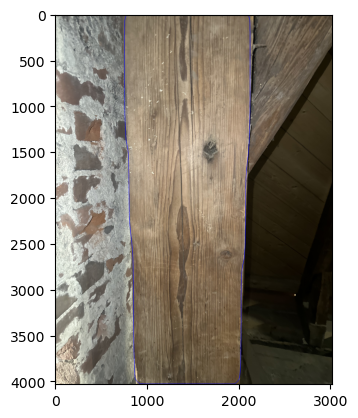

Mask_0_0 area: 4883093.5
Mask_1_0 area: 583772.0
Mask_2_0 area: 1636205.0
Mask_3_0 area: 2383691.5


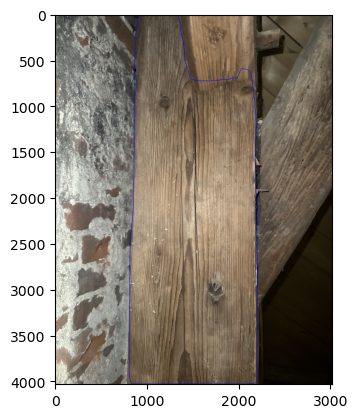

Mask_0_0 area: 3721022.5
Mask_1_0 area: 1182757.5


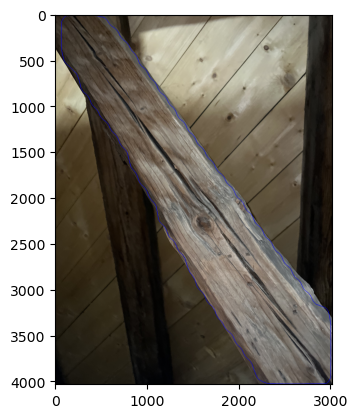

In [52]:
import os, json, cv2, random
import numpy as np


#FUNCTION: Select the mask with the largest area using Shoelace formula
def polygon_area(polygon):
    polygon = np.array(polygon)
    x = polygon[:, 0]
    y = polygon[:, 1]
    return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))


# FUNCTION: Simplified polygon using Visvalingam–Whyatt algorithm

def vw_simplify(polygon, threshold=0.5):
    def area_of_triangle(p1, p2, p3):
        return 0.5 * abs(p1[0] * (p2[1] - p3[1]) + p2[0] * (p3[1] - p1[1]) + p3[0] * (p1[1] - p2[1]))
    
    points = np.array(polygon, dtype=np.float32)
    is_removed = np.zeros(points.shape[0], dtype=bool)
    areas = np.array([area_of_triangle(points[i - 1], points[i], points[i + 1]) for i in range(1, len(points) - 1)])
    
    while len(areas) > 0 and np.min(areas) < threshold:
        min_index = np.argmin(areas) + 1
        is_removed[min_index] = True
        points = points[~is_removed]
        print(f"Removed point at index {min_index}, remaining points: {len(points)}")
        if len(points) < 3:
            break
        areas = np.array([area_of_triangle(points[i - 1], points[i], points[i + 1]) for i in range(1, len(points) - 1)])
        print(f"Recomputed areas: {areas}")
    return points

#FUNCTION: convex_hull

def ch_simplify(polygon):
    points = np.array(polygon, dtype=np.int32).reshape((-1, 1, 2))
    hull = cv2.convexHull(points)
    return hull

def save_json(json_name, outputs, output_folder):
    json_output_file_path = os.path.join(output_folder, f"{file_name.rsplit('.', 1)[0]}.json")
    os.makedirs(os.path.dirname(json_output_file_path), exist_ok=True)
    with open(json_output_file_path, 'w') as json_file:
        json.dump(outputs, json_file, indent=4)

def draw_polygon_on_image(image, polygon):
    pts = np.array(polygon, np.int32)
    if pts.shape[-1] == 1:
        pts = pts.reshape((-1, 2))
    pts = pts.reshape((-1, 1, 2))
    cv2.polylines(image, [pts], isClosed=True, color=(255, 0, 0), thickness=3) 
    return image

def save_test_image(image, name, output_folder):
    output_image_path = os.path.join(output_folder, name)
    os.makedirs(os.path.dirname(output_image_path), exist_ok=True)
    cv2.imwrite(output_image_path, image)


max_area = 0
max_area_index = -1

input_folder = '/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Transformation/1-input_reg'
output_folder = '/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Transformation/2-output_seg'
output_json = '/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Transformation/3-output_json'
output_max = '/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Transformation/4-output_max'


# Function: Load JSON
for json_name in os.listdir(output_folder):
    if json_name.endswith('.json'):
        with open(os.path.join(output_folder, json_name), 'r') as f:
            seg_output = json.load(f)

        # Function: Save the name of original JSON
        json_name = os.path.basename(json_name)

        max_area = 0
        max_area_instance = None

        # Function: Loop through the masks and select the max area
        for i, instance in enumerate(seg_output['instances']):
            for j, polygon_data in enumerate(instance['mask']):
                polygon = polygon_data['polygon']
                area = polygon_area(polygon)
                print(f"Mask_{i}_{j} area: {area}")
                if area > max_area:
                    max_area = area
                    
                    max_area_instance = {
                        "class": instance["class"],
                        "box": instance["box"],
                        "score": instance["score"],
                        "mask": [{"polygon": polygon}]
                    }
                    

        if max_area_instance:
            # #- Simplify the polygon using Visvalingam–Whyatt algorithm
            # vw_simplified_polygon = vw_simplify(max_area_instance["mask"][0]["polygon"])
            # optimal_quad_pts = ch_simplify(vw_simplified_polygon)
            
            #- Simplify the polygon using Convex Hull
            optimal_quad_pts = vw_simplify(max_area_instance["mask"][0]["polygon"])

            max_area_instance["mask"][0]["polygon"] = optimal_quad_pts.tolist() 
            
            # print(max_area_instance["mask"][0]["polygon"])


            json_max_name = json_name.split('.')[0] + "_max_area"
            save_json(json_max_name, max_area_instance, output_json)
            
            image_name = json_name.replace('.json', '.jpeg')
            if image_name.startswith("test_"):
                image_name = image_name[5:] 
                
            image_path = os.path.join(input_folder, image_name)
            if os.path.exists(image_path):
                image_org = cv2.imread(image_path)
                image_with_polygon = draw_polygon_on_image(image_org.copy(), max_area_instance["mask"][0]["polygon"])
                
                plt.imshow(cv2.cvtColor(image_with_polygon, cv2.COLOR_BGR2RGB))
                plt.show()

                save_test_image(image_with_polygon, image_name, output_max)

### simplify the max area

[[[ 401   14]]

 [[ 437   15]]

 [[ 448   17]]

 [[ 478   23]]

 [[ 487   25]]

 [[ 500   28]]

 [[ 508   30]]

 [[ 523   34]]

 [[ 530   36]]

 [[ 536   38]]

 [[ 538   39]]

 [[ 543   43]]

 [[ 560   60]]

 [[ 671  175]]

 [[ 791  325]]

 [[ 794  329]]

 [[2962 3223]]

 [[2970 3235]]

 [[2973 3240]]

 [[2974 3242]]

 [[2977 3254]]

 [[2980 3267]]

 [[2983 3281]]

 [[2985 3291]]

 [[2987 3302]]

 [[2990 3319]]

 [[2994 3345]]

 [[2995 3352]]

 [[2997 3367]]

 [[2999 3383]]

 [[3000 3513]]

 [[3000 3807]]

 [[2999 3955]]

 [[2998 3962]]

 [[2996 3967]]

 [[2993 3974]]

 [[2988 3984]]

 [[2984 3991]]

 [[2978 4000]]

 [[2975 4004]]

 [[2970 4010]]

 [[2959 4021]]

 [[2954 4025]]

 [[2950 4028]]

 [[2948 4029]]

 [[2928 4030]]

 [[2721 4031]]

 [[2479 4031]]

 [[2390 4030]]

 [[2353 4029]]

 [[2319 4028]]

 [[2305 4024]]

 [[2287 4018]]

 [[2279 4015]]

 [[2264 4009]]

 [[2249 4002]]

 [[2236 3995]]

 [[2231 3992]]

 [[2223 3987]]

 [[2220 3985]]

 [[2216 3982]]

 [[2211 3977]]

 [[2207 

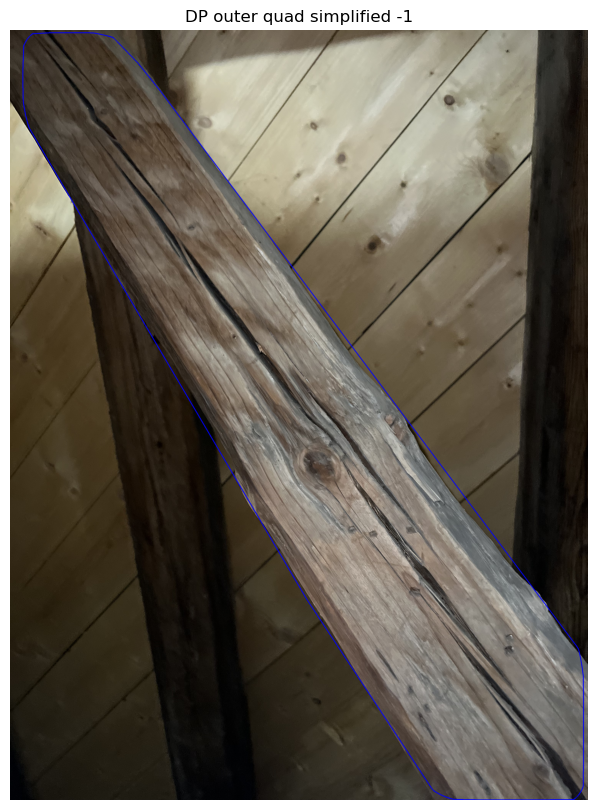

In [43]:
max_polygon = max_area_instance["mask"][0]["polygon"]


vw_simplified_polygon = vw_simplify(max_polygon)
optimal_quad_pts = ch_simplify(vw_simplified_polygon)

print(simplified_polygon)

image_outer_quad = draw_polygon_on_image(image_org.copy(), optimal_quad_pts)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image_outer_quad, cv2.COLOR_BGR2RGB))
plt.title(f"DP outer quad simplified {max_area_index}")
plt.axis('off')
plt.show()

image_with_polygon = draw_polygon_on_image(image_org.copy(),optimal_quad_pts)

save_test_image(image_with_polygon, image_name, output_max)